In [9]:
import numpy as np
from scipy.stats import pearsonr, spearmanr


def pearson_correlations(x, y):
    """
    Pearson相关系数

    :param x: 向量x
    :param y: 向量y
    :return rho: (Pearson)相关系数
    """
    cov = np.cov(x, y, bias=True)[0][1]  # 有偏估计, 当样本长度确定时
    # cov = np.cov(x, y)[0][1]  # 无偏估计
    std_x = np.std(x)
    std_y = np.std(y)
    
    rho = cov / (std_x * std_y)
    
    return rho


def spearmans_rank_correlation(x, y):
    """
    Spearman相关系数

    :param x: 向量x
    :param y: 向量y
    :return rho: spearman相关系数
    """
    # 合并向量
    # [[-6, 8, -4, 10],
    #  [-7, -5, 7, 9]]
    spearman_matrix = np.vstack((x, y))

    # 得到排序后的x和y的rank值(因为x与y同型)
    # [1, 2, 3, 4]
    rank = np.arange(1, len(x) + 1)

    # 将x的rank值向量合并到矩阵上
    # [[-6, -4, 8, 10],
    #  [-7, 7, -5, 9],
    #  [1, 2, 3, 4]]
    spearman_matrix = spearman_matrix[:, spearman_matrix[0].argsort()]
    spearman_matrix = np.vstack((spearman_matrix, rank))

    # 将y的rank值向量合并到矩阵上
    # [[-6, 8, -4, 10],
    #  [-7, -5, 7, 9],
    #  [1, 3, 2, 4],
    #  [1, 2, 3, 4]]
    spearman_matrix = spearman_matrix[:, spearman_matrix[1].argsort()]
    spearman_matrix = np.vstack((spearman_matrix, rank))

    # 重新按照x的rank值排列
    # [[-6, -4, 8, 10],
    #  [-7, 7, -5, 9],
    #  [1, 2, 3, 4],
    #  [1, 3, 2, 4]]
    spearman_matrix = spearman_matrix[:, spearman_matrix[0].argsort()]

    # 求squa(d)
    # [0, 1, 1, 0]
    d_square = (spearman_matrix[2] - spearman_matrix[3]) ** 2

    rho = 1 - (6 * sum(d_square) / (len(x) * (len(x) ** 2 - 1)))

    return rho


def std_dev(data):
    # Get number of observations
    n = len(data)
    # Calculate mean
    mean = sum(data) / n
    # Calculate deviations from the mean
    deviations = sum([(x - mean)**2 for x in data])
    # Calculate Variance & Standard Deviation
    variance = deviations / (n - 1)
    s = variance**(1/2)
    return s


# Sharpe Ratio From Scratch
def sharpe_ratio(data, risk_free_rate=0.0):
    # Calculate Average Daily Return
    mean_daily_return = sum(data) / len(data)
    # Calculate Standard Deviation
    s = std_dev(data)
    # Calculate Daily Sharpe Ratio
    daily_sharpe_ratio = (mean_daily_return - risk_free_rate) / s
    # Annualize Daily Sharpe Ratio
    sharpe_ratio = 12**(1/2) * daily_sharpe_ratio
    
    return sharpe_ratio


x = np.random.binomial(1, 0.5*np.ones(500))


# y_1 = np.random.uniform(0, 0.5, 500)
# y_2 = np.random.uniform(0.5, 1.0, 500)




y_1 = np.random.binomial(1, 0.52*np.ones(500))

# y = y_1*(y==0) + y_2*(y==1)

y_2 = np.random.uniform(0,1,500)

print(x.shape)

# print(y)

# print(x)

# spe_corre = spearmans_rank_correlation(x, y)
# pea_corre = pearson_correlations(x, y)

spe_corre = spearmanr(x, y_1)
pea_corre = pearsonr(x, y_2)

print('spe_corre:', spe_corre)
print('pea_corre:', pea_corre)

# sp_ratio = sharpe_ratio(y)
# print('sp_ratio:', sp_ratio)

# sp_ratio_v2 = np.mean(y)/np.std(y)
# print('sp_ratio_v2:', sp_ratio_v2)


(500,)
spe_corre: SpearmanrResult(correlation=-0.04471144618558274, pvalue=0.31838845351752076)
pea_corre: (-0.12495045160346126, 0.005142697653557932)


In [1]:
import numpy as np
from utils import *
import torch
from model_debug import *
import os.path as op
import pandas as pd

import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}


start_year = 1993
period = 8
predict_days = 5
batch_size = 100


def generate_loaders():
    year=start_year
    images = np.memmap(op.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_images.dat"), dtype=np.uint8, mode='r').reshape(
                            (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
    print(images.shape)
    years = np.arange(year+1,year+int(period))
    print(years)
    for y in years:
        img = np.memmap(op.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{y}_images.dat"), dtype=np.uint8, mode='r').reshape(
                            (-1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
        print('year:',y,'size:',img.shape)
        images = np.concatenate((images,img), axis=0)
    
    label_df = pd.read_feather(op.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather"))
    rets = np.array(label_df['Ret_%sd'%predict_days])
    for y in years:
        lb_df = pd.read_feather(op.join("./monthly_20d", f"20d_month_has_vb_[20]_ma_{y}_labels_w_delay.feather"))
        ret = np.array(lb_df['Ret_%sd'%predict_days])
        print('year:',y,'size:',ret.shape)
        rets = np.append(rets,ret)
    print('final rets shape:',rets.shape)

    images = images/255.0
    rets[rets>0] = 1
    rets[rets!=1] = 0
    print('postive num:',sum(rets==1),'negative num:',sum(rets==0))

    data_x = torch.from_numpy(images).type(torch.FloatTensor)
    data_y = torch.from_numpy(rets).to(torch.int64) 

    data_x = torch.unsqueeze(data_x,dim=1)
    # data_y = torch.unsqueeze(data_y,dim=1)

    f1= open("train_idx.txt","r")   
    train_idx = f1.read()    
    f1.close() 
    f2= open("test_idx.txt","r")   
    test_idx = f2.read()    
    f2.close() 

    train_idx = train_idx.split(',')
    test_idx = test_idx.split(',')
    train_idx = [int(e) for e in train_idx]
    test_idx = [int(e) for e in test_idx]

    print('train_size:',len(train_idx))
    print('test_size',len(test_idx))
    
    train_x = data_x[train_idx]
    train_y = data_y[train_idx]
    test_x = data_x[test_idx]
    test_y = data_y[test_idx]

        
    # train_dataset = TensorDataset(train_x,train_y)
    # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = TensorDataset(test_x,test_y)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # return train_dataset, test_dataset, train_loader, test_loader

    return test_dataset

test_dataset = generate_loaders()
        

/home/hbo/.conda/envs/hbopy36/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(85644, 64, 60)
[1994 1995 1996 1997 1998 1999 2000]
year: 1994 size: (94750, 64, 60)
year: 1995 size: (97707, 64, 60)
year: 1996 size: (102974, 64, 60)
year: 1997 size: (107311, 64, 60)
year: 1998 size: (106201, 64, 60)
year: 1999 size: (100284, 64, 60)
year: 2000 size: (98148, 64, 60)
year: 1994 size: (94750,)
year: 1995 size: (97707,)
year: 1996 size: (102974,)
year: 1997 size: (107311,)
year: 1998 size: (106201,)
year: 1999 size: (100284,)
year: 2000 size: (98148,)
final rets shape: (793019,)
postive num: 394894 negative num: 398125
train_size: 555113
test_size 237906


val_imag:shape torch.Size([1, 1, 64, 60])
val_imag:shape torch.Size([1, 1, 64, 60])
val_imag:shape torch.Size([1, 1, 64, 60])
val_imag:shape torch.Size([1, 1, 64, 60])
val_imag:shape torch.Size([1, 1, 64, 60])


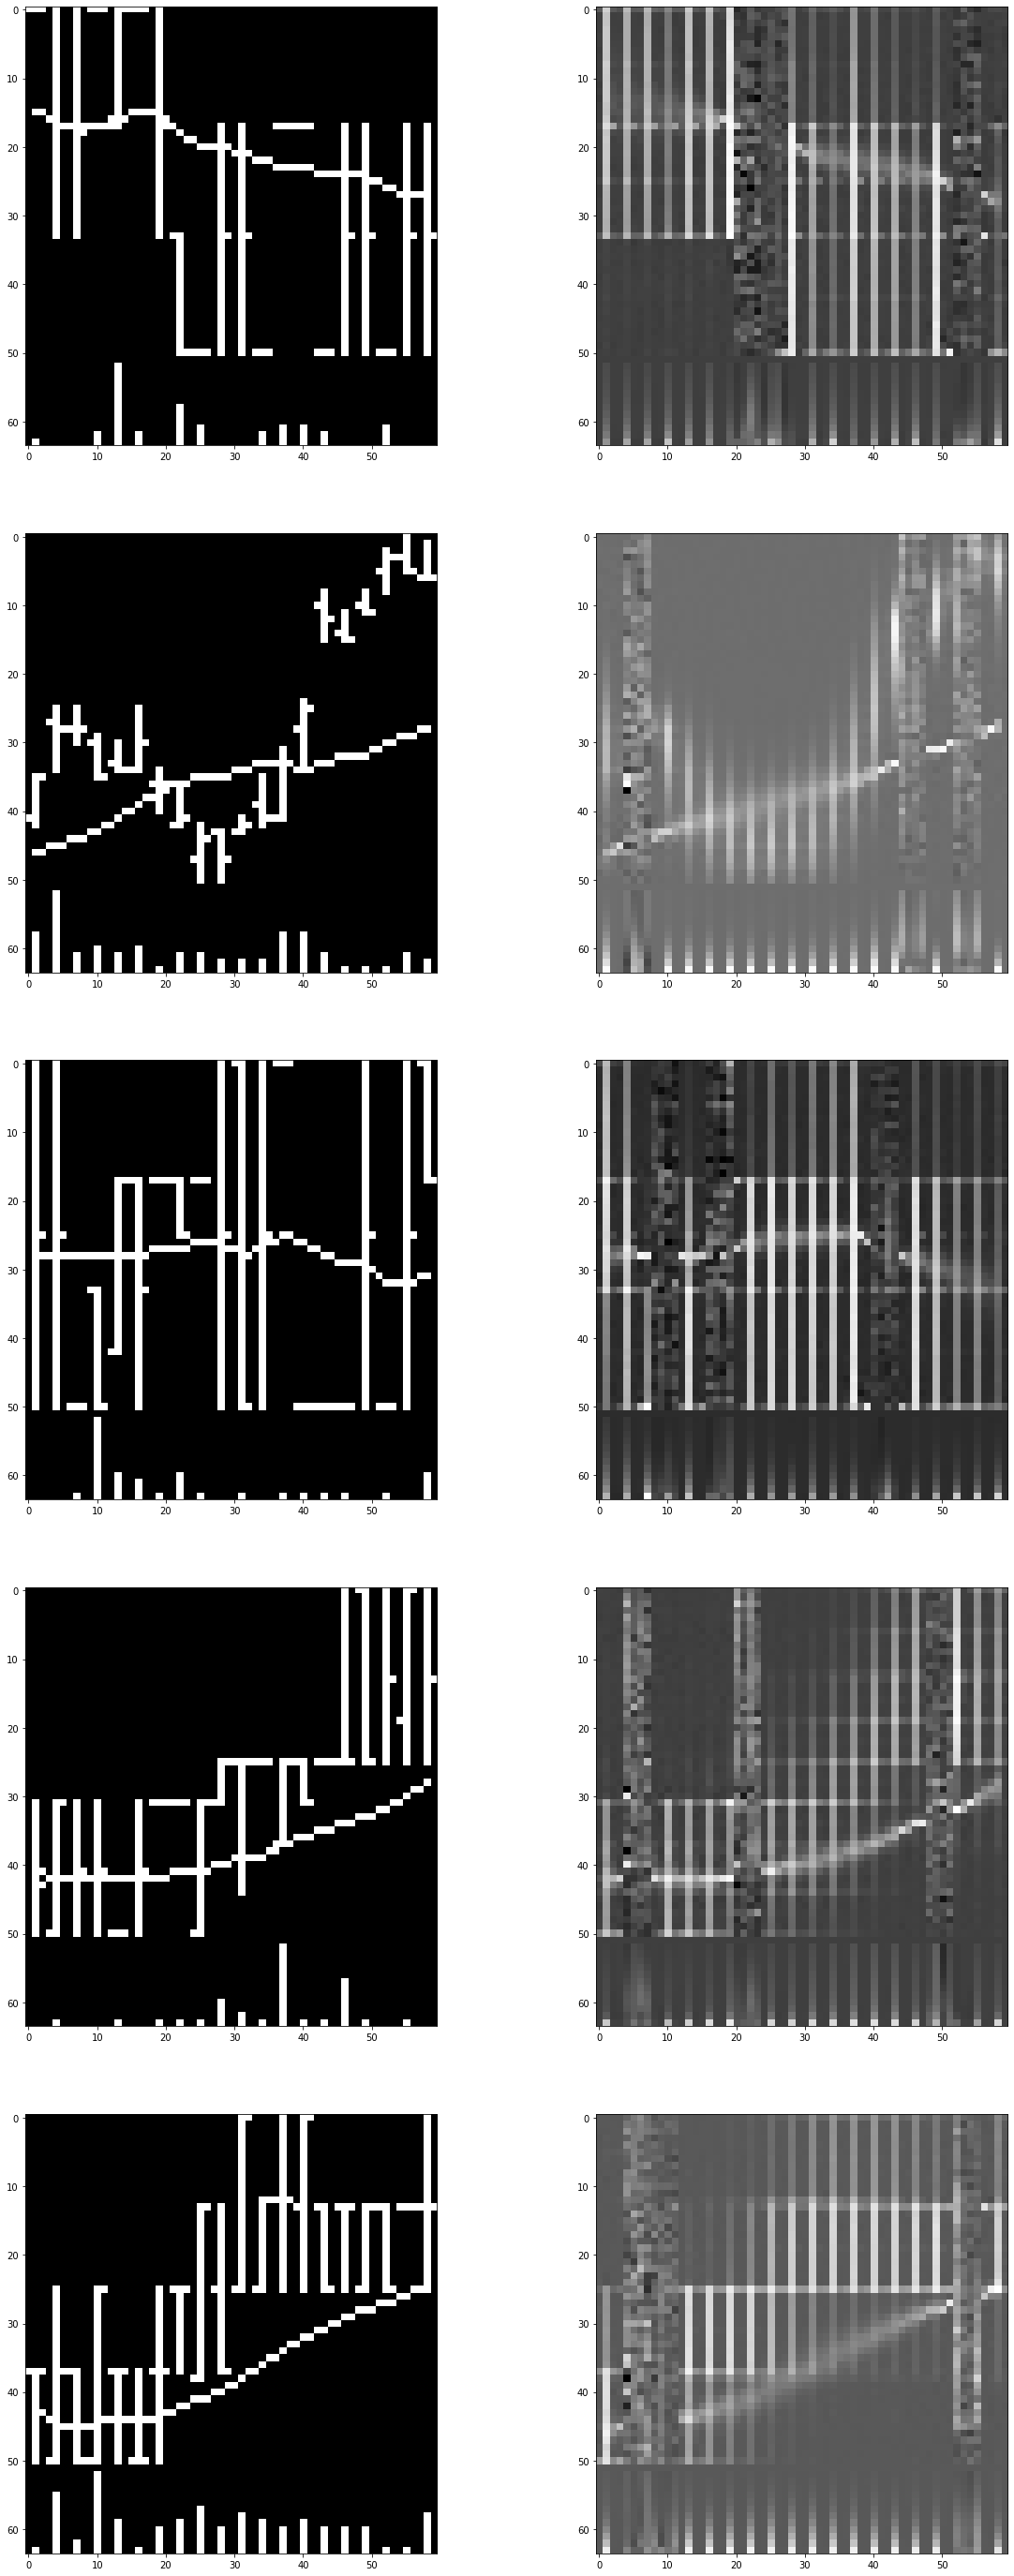

<Figure size 432x288 with 0 Axes>

In [10]:
mask_ratio = 0.75

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = MAE_ViT(mask_ratio=mask_ratio).to(device)

model_path = 'mask_ratio(%s)-width(4)-m20d-vit-t-mae.pt'%str(mask_ratio)

model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')).state_dict())


plt.figure(figsize=(20,50))

for j in range(5):
    model.eval()
    with torch.no_grad():
        # val_img = torch.stack([test_dataset[i][0] for i in range(5)])
        val_img = torch.unsqueeze(test_dataset[j][0],dim=0)
        print('val_imag:shape', val_img.shape)
        val_img = val_img.to(device)
        predicted_val_img, mask = model(val_img)

        val_img = np.squeeze(val_img.detach().cpu().numpy(), 0)*255
        predicted_val_img = np.squeeze(predicted_val_img.detach().cpu().numpy(), 0)*255

        plt.subplot(5,2,2*j+1)
        plt.imshow(np.squeeze(val_img, 0), cmap='gray')
        plt.subplot(5,2,2*j+2)
        plt.imshow(np.squeeze(predicted_val_img,0), cmap='gray')

plt.show()
plt.savefig('reconstruct_image.png')